<a href="https://colab.research.google.com/github/sorayutmild/Unsupervised-Thai-Document-Clustering-with-Sanook-news/blob/main/Document_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# จัดกลุ่มบทความ โดยใช้ unsupervised learning model
## Fisrt method, Hard clustering
### One document can be only one cluster
### 1. Text representation (Bag-of-Word, Doc2vec, Transformer embedding)
### 2. Clustering model (e.g., k-means clustering, Hierarchical clustering)

\
## Second method, Soft clustering (not cover)
### One document can be multiple clusters.
### Topic modeling (LDA)


# Topic
* Download dataset
* Text preprocessing
* Text representation
    * Bag-of-Words
    * Transformer Embedding
    * Clustering model
* Evaluation
* Error analysis

In [1]:
!nvidia-smi

Sun Jul 24 18:28:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip -q install pythainlp==3.0.0
!pip -q install python-crfsuite

     |████████████████████████████████| 11.5 MB 19.6 MB/s 
     |████████████████████████████████| 965 kB 13.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import glob
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
import re
import os
from tqdm.auto import tqdm

In [4]:
text_file_folder = 'text_files'

## Download dataset

In [5]:
# https://drive.google.com/file/d/16IhVdoLuFso28TVIpYoIogco_LZg1e17/view?usp=sharing
!gdown --id 16IhVdoLuFso28TVIpYoIogco_LZg1e17

# https://drive.google.com/file/d/1chetbLnMLRIqt0U8m3JMzO0xguGUEHX6/view?usp=sharing
!gdown --id 1chetbLnMLRIqt0U8m3JMzO0xguGUEHX6

!unzip -q ./text_files.zip

Streaming output truncated to the last 5000 lines.
text_files/สุขภาพ_43.txt:  mismatching "local" filename (text_files/р╕кр╕╕р╕Вр╕ар╕▓р╕Ю_43.txt),
         continuing with "central" filename version
text_files/สุขภาพ_430.txt:  mismatching "local" filename (text_files/р╕кр╕╕р╕Вр╕ар╕▓р╕Ю_430.txt),
         continuing with "central" filename version
text_files/สุขภาพ_431.txt:  mismatching "local" filename (text_files/р╕кр╕╕р╕Вр╕ар╕▓р╕Ю_431.txt),
         continuing with "central" filename version
text_files/สุขภาพ_432.txt:  mismatching "local" filename (text_files/р╕кр╕╕р╕Вр╕ар╕▓р╕Ю_432.txt),
         continuing with "central" filename version
text_files/สุขภาพ_433.txt:  mismatching "local" filename (text_files/р╕кр╕╕р╕Вр╕ар╕▓р╕Ю_433.txt),
         continuing with "central" filename version
text_files/สุขภาพ_434.txt:  mismatching "local" filename (text_files/р╕кр╕╕р╕Вр╕ар╕▓р╕Ю_434.txt),
         continuing with "central" filename version
text_files/สุขภาพ_435.txt:  mismatching "local" fil

In [6]:
df = pd.read_csv('sanook_news_all.csv')
display(df.head())
df.info()

,Title,Link,Date,Views,File_name,Label
0,คะแนนเลือกตั้ง 2562: เกาะติดผลเลือกตั้ง วินาที...,https://www.sanook.com/news/7722298/,5 เม.ย. 62,"1,925,802",การเมือง_1.txt,การเมือง
1,คอหวยตื่น! ป้ายทะเบียนใหม่รถนายกฯ ลุ้นงวด16ต.ค.,https://www.sanook.com/news/1148178/,16 ต.ค. 55,"1,074,542",การเมือง_2.txt,การเมือง
2,อัพเดตนาทีต่อนาที! เหตุการณ์หลังรัฐประหาร,https://www.sanook.com/news/1596593/,22 พ.ค. 57,"788,755",การเมือง_3.txt,การเมือง
3,ทำความรู้จักกับ มาตรา 44 ใช้แทนกฎอัยการศึก,https://www.sanook.com/news/1773902/,2 เม.ย. 58,"736,582",การเมือง_4.txt,การเมือง
4,ผลการเลือกตั้ง 2562 นับคะแนนล่าสุด 94% “พลังปร...,https://www.sanook.com/news/7723326/,25 มี.ค. 62,"706,607",การเมือง_5.txt,การเมือง


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14926 entries, 0 to 14925
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      14926 non-null  object
 1   Link       14926 non-null  object
 2   Date       14926 non-null  object
 3   Views      14926 non-null  object
 4   File_name  14926 non-null  object
 5   Label      14926 non-null  object
dtypes: object(6)
memory usage: 699.8+ KB


In [7]:
df['Label'].value_counts()

อาชญากรรม      1868
ข่าวบันเทิง    1862
การเมือง       1712
ข่าวไอที       1676
ข่าวรถยนต์     1501
ข่าวเกมส์      1499
สุขภาพ         1352
ข่าวกีฬา       1304
ดูดวง          1100
ข่าวการเงิน    1052
Name: Label, dtype: int64

remove duplicate link rows

In [8]:
df = df.drop_duplicates('Link').reset_index()
df

,index,Title,Link,Date,Views,File_name,Label
0,0,คะแนนเลือกตั้ง 2562: เกาะติดผลเลือกตั้ง วินาที...,https://www.sanook.com/news/7722298/,5 เม.ย. 62,"1,925,802",การเมือง_1.txt,การเมือง
1,1,คอหวยตื่น! ป้ายทะเบียนใหม่รถนายกฯ ลุ้นงวด16ต.ค.,https://www.sanook.com/news/1148178/,16 ต.ค. 55,"1,074,542",การเมือง_2.txt,การเมือง
2,2,อัพเดตนาทีต่อนาที! เหตุการณ์หลังรัฐประหาร,https://www.sanook.com/news/1596593/,22 พ.ค. 57,"788,755",การเมือง_3.txt,การเมือง
3,3,ทำความรู้จักกับ มาตรา 44 ใช้แทนกฎอัยการศึก,https://www.sanook.com/news/1773902/,2 เม.ย. 58,"736,582",การเมือง_4.txt,การเมือง
4,4,ผลการเลือกตั้ง 2562 นับคะแนนล่าสุด 94% “พลังปร...,https://www.sanook.com/news/7723326/,25 มี.ค. 62,"706,607",การเมือง_5.txt,การเมือง
...,...,...,...,...,...,...,...
14853,14921,คลิประทึก! อาชีวะไล่ยิง ม.3 กลางถนนโคม่า คาดแก...,https://www.sanook.com/news/2008926/,9 มิ.ย. 59,"94,112",อาชญากรรม_1864.txt,อาชญากรรม
14854,14922,กรมราชทัณฑ์ประหารชีวิต นักโทษคดีฆ่าชิงทรัพย์ ร...,https://www.sanook.com/news/6858238/,18 มิ.ย. 61,"94,060",อาชญากรรม_1865.txt,อาชญากรรม
14855,14923,สารวัตรทางด่วนซิ่ง จยย.ชนท้ายแท็กซี่ดับคาโทลเวย์,https://www.sanook.com/news/1187022/,20 พ.ค. 56,"94,001",อาชญากรรม_1866.txt,อาชญากรรม
14856,14924,2 พี่น้องติดในกระโปรงท้ายรถ ขาดอากาศ! พี่ดับน้...,https://www.sanook.com/news/1200761/,3 ส.ค. 56,"93,985",อาชญากรรม_1867.txt,อาชญากรรม


## Text preprocessing

In [9]:
def read_text_file(text_path):
    with open(text_path) as f:
        texts = [line.strip() for line in f.readlines()]
    return texts

def get_raw_text(text_list:list):
    '''
    text_list : list of text paragraphs
    return : raw text
    '''
    return ' '.join(text_list)

# def get_list_text(text):
#     '''
#     get list text, separate with paragraph
#     '''
#     return text.split('\n')

def include_title(title, text_list):
    return [title] + text_list

def tokenize(text):
    tokenized_text = [word for word in word_tokenize(text) if word and not re.search(pattern=r"\s+", string=word)] # segment and not ' word '
    return tokenized_text

def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_special_char(text):
    special_char = r"""[~@&#<>,}{()*:;"'-+=_?"\"/$%^%$!ๆ‘’“”…่่่่่่่่่ạễ•′–0-9]"""
    text = re.sub(special_char, '', text)
    text = text.replace("[", '').replace("]", '').replace('-', '')
    return text

def clean_text(text):
    '''
    1. link
    2. symbols, numbers, special characters
    '''
    #pre rules
    text = text.lower().strip()
    text = replace_url(text)
    text = replace_special_char(text)
    cleaned_text = text

    return cleaned_text


# read_text_file('text_files/ข่าวไอที_1647.txt')
# test_text = '[11-กุมภาพันธ์-2556] ไอบัดดี้โฟนเรา..วันนี้ มีบทความดีๆมาฝาก เกี่ยวกับมารยาทการใช้มือถือที่เราต้องใส่ใจสังคมคนรอบๆข้างตัวเรา (บ้าง)...โทรศัพท์มือถือในยุคปัจจุบันกลายเป็นปัจจัยที่4 ของคนเราไปเสียแล้ว ไม่ว่าเราจะนั่งชิลๆ อยู่กับบ้าน หรือแม้กระทั่งต้องออกนอกบ้านก็ไม่สามารถอยู่ห่างมือถือได้เลย'
# process_text = tokenize(test_text)

In [10]:
df['File_path'] = [os.path.join(text_file_folder, fn) for fn in df['File_name'].values]
df['list_text'] = df['File_path'].map(read_text_file)
df['list_text'] = [include_title(t, lt) for t, lt in zip(df['Title'].values, df['list_text'].values)]
df['raw_text'] = df['list_text'].map(get_raw_text)
df['cleaned_text'] = df['raw_text'].map(clean_text)
# df['list_clean_text'] = df['cleaned_text'].map(get_list_text)
df.head()

,index,Title,Link,Date,Views,File_name,Label,File_path,list_text,raw_text,cleaned_text
0,0,คะแนนเลือกตั้ง 2562: เกาะติดผลเลือกตั้ง วินาที...,https://www.sanook.com/news/7722298/,5 เม.ย. 62,"1,925,802",การเมือง_1.txt,การเมือง,text_files/การเมือง_1.txt,[คะแนนเลือกตั้ง 2562: เกาะติดผลเลือกตั้ง วินาท...,คะแนนเลือกตั้ง 2562: เกาะติดผลเลือกตั้ง วินาที...,คะแนนเลือกตั้ง เกาะติดผลเลือกตั้ง วินาทีตอวิน...
1,1,คอหวยตื่น! ป้ายทะเบียนใหม่รถนายกฯ ลุ้นงวด16ต.ค.,https://www.sanook.com/news/1148178/,16 ต.ค. 55,"1,074,542",การเมือง_2.txt,การเมือง,text_files/การเมือง_2.txt,[คอหวยตื่น! ป้ายทะเบียนใหม่รถนายกฯ ลุ้นงวด16ต....,คอหวยตื่น! ป้ายทะเบียนใหม่รถนายกฯ ลุ้นงวด16ต.ค...,คอหวยตืน ป้ายทะเบียนใหมรถนายกฯ ลุ้นงวดต.ค. คอห...
2,2,อัพเดตนาทีต่อนาที! เหตุการณ์หลังรัฐประหาร,https://www.sanook.com/news/1596593/,22 พ.ค. 57,"788,755",การเมือง_3.txt,การเมือง,text_files/การเมือง_3.txt,"[อัพเดตนาทีต่อนาที! เหตุการณ์หลังรัฐประหาร, รั...",อัพเดตนาทีต่อนาที! เหตุการณ์หลังรัฐประหาร รัฐป...,อัพเดตนาทีตอนาที เหตุการณ์หลังรัฐประหาร รัฐประ...
3,3,ทำความรู้จักกับ มาตรา 44 ใช้แทนกฎอัยการศึก,https://www.sanook.com/news/1773902/,2 เม.ย. 58,"736,582",การเมือง_4.txt,การเมือง,text_files/การเมือง_4.txt,"[ทำความรู้จักกับ มาตรา 44 ใช้แทนกฎอัยการศึก, ห...",ทำความรู้จักกับ มาตรา 44 ใช้แทนกฎอัยการศึก หลั...,ทำความรู้จักกับ มาตรา ใช้แทนกฎอัยการศึก หลังจ...
4,4,ผลการเลือกตั้ง 2562 นับคะแนนล่าสุด 94% “พลังปร...,https://www.sanook.com/news/7723326/,25 มี.ค. 62,"706,607",การเมือง_5.txt,การเมือง,text_files/การเมือง_5.txt,[ผลการเลือกตั้ง 2562 นับคะแนนล่าสุด 94% “พลังป...,ผลการเลือกตั้ง 2562 นับคะแนนล่าสุด 94% “พลังปร...,ผลการเลือกตั้ง นับคะแนนลาสุด พลังประชารัฐเพื...


In [11]:
# clear empty document (only have title)
df = df[df["raw_text"]!=df["Title"]]
df.reset_index(inplace=True, drop=True)
df.shape

(14821, 11)

In [12]:
df['cleaned_text'][100]

'สุดอาลัย.. คุณหญิงแจมใส พาลูก กราบศพบรรหาร ผู้สือขาวรายงานวา  เม.ย. ทีศาลากลางน้ำ วัดเทพศิรินทราวาสราชวรวิหาร บรรยากาศการรดน้ำศพ นายบรรหาร ศิลปอาชา อดีตนายกรัฐมนตรี ทีถึงแกอนิจกรรม เมือชวงเช้าของวันที  เม.ย. ได้มีบุคคลสำคัญจากแวดวงการเมือง ทยอยเข้ารดน้ำศพเป็นจำนวนมาก ขณะที พล.อ.ประยุทธ์ จันทร์โอชา นายกรัฐมนตรีและหัวหน้าคณะรักษาความสงบแหงชาติ คสช. นายทักษิณ ชินวัตร น.ส.ยิงลักษณ์ ชินวัตร และ นายอภิสิทธิ์ เวชชาชีวะ อดีตนายกฯ ได้สงพวงหรีดดอกไม้รวมไว้อาลัย จากนั้นเวลา . น. พล.อ.เปรม ติณสูลานนท์ ประธานองคมนตรีและรัฐบุรุษ เดินทางถึงศาลากลางน้ำ เพือเป็นประธานในพิธีพระราชทานน้ำหลวงอาบศพ โดยกอนเริมพิธี พล.อ.เปรม ได้พูดคุยกับคุณหญิงแจมใสและครอบครัว โดย พล.อ.เปรม ได้วางมือแตะไปทีแขนของคุณหญิงแจมใสเบา เพือให้กำลังใจด้วย โดยคุณหญิงแจมใส ศิลปอาชา พร้อมบุตรทั้ง  กัญจนา วราวุธ ปาริชาติ และครอบครัวศิลปอาชา ได้กราบขอขมาศพนายบรรหารเป็นครั้งสุดท้าย กอนประกอบพิธีบรรจุลงโลง ซึงบรรยากาศเต็มไปด้วยความอาลัยรัก ทั้งนี้ จะมีพระพิธีธรรม สวดพระอภิธรรมในพระบรมราชานุเคราะห์  คืน ตั้งแตคืนนี้จนถึงวันที  เม.ย.  ณ ศาลา

## Hard clustering

### Text representation

#### Bag-of-Word

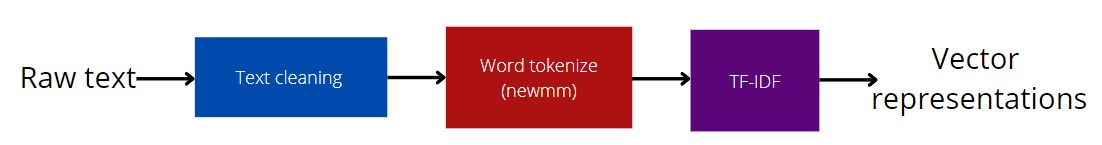

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=tokenize, min_df=100, sublinear_tf=True, )
tfidf_fit = tfidf.fit(df['cleaned_text'])
text_vector = tfidf_fit.transform(df['cleaned_text'])
text_vector.shape # (14821, 7613) unclean # (14821, 4102) clean

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


(14821, 4119)

In [14]:
tfidf_fit.get_feature_names_out()

array(['.', '..', '...', ..., 'ไฮโซ', 'ไฮไลท์', '์'], dtype=object)

In [15]:
word = pd.DataFrame({
    'word':tfidf_fit.get_feature_names_out()
})

word.to_csv('word.csv', index=False, encoding='utf-8-sig')

In [16]:
text_vector.toarray()

array([[0.03987482, 0.        , 0.        , ..., 0.        , 0.        ,
        0.0466223 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0767498 , 0.03133549, 0.        , ..., 0.        , 0.        ,
        0.05021131],
       ...,
       [0.03790337, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02983202, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
np.save('tfidf_vectors', text_vector, allow_pickle=True)

#### Transformer embedding

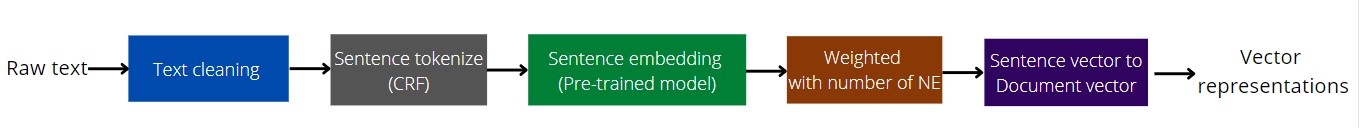

Sentence embedding: [SimCSE:Simple Contrastive Learning of Sentence Embeddings](https://arxiv.org/pdf/2104.08821.pdf)

Sentence vector to Document vector: [A Text Document Clustering Method Based on Weighted BERT Model](https://ieeexplore.ieee.org/document/9085059)

In [18]:
!pip -q install sentence_transformers==2.1.0

     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 4.4 MB 53.1 MB/s 
     |████████████████████████████████| 6.6 MB 59.4 MB/s 
     |████████████████████████████████| 1.2 MB 63.9 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 596 kB 72.1 MB/s 


In [19]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
from pythainlp.tokenize import sent_tokenize

/usr/local/lib/python3.7/dist-packages/huggingface_hub/snapshot_download.py:11: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  FutureWarning,


In [20]:
model_name = 'mrp/simcse-model-wangchanberta' # 'sorayutmild/simcse-model-wangchanberta-finetuned-sanook-news' # 'mrp/simcse-model-wangchanberta' # monsoon-nlp/bert-base-thai' # 'xlm-roberta-base' # airesearch/wangchanberta-base-att-spm-uncased'
# word_embedding_model = models.Transformer(model_name, max_seq_length=256)
model = SentenceTransformer(model_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/766 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/421M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/305 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [21]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 32, 'do_lower_case': False}) with Transformer model: CamembertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [22]:
# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='cls')
# model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [23]:
# for test feature extraction

t1 = ['วันนี้อากาศดีมาก']
t2 = ['วันนี้อากาศดีมากที่สุดในรอบปี', 'อากาศดีจังเลยวันนี้', 'ท้องฟ้าแจ่มใสดีจัง', 'อยากกินข้าวขาหมูเนอะ']

a = model.encode(t1, normalize_embeddings=True)
b = model.encode(t2, normalize_embeddings=True)

# cosine similarity
np.inner(a, b)

array([[0.7993202 , 0.77808964, 0.72144926, 0.65950686]], dtype=float32)

In [24]:
from pythainlp.tag import NER
ner = NER(engine="thainer")

Corpus: thainer
- Downloading: thainer 1.5


100%|██████████| 1637304/1637304 [00:00<00:00, 138928015.14it/s]


In [25]:
def number_of_ner(text):
    text_ner = ner.tag(text, tag=True, pos=False)
    # print(text_ner)
    n_ner = len(re.findall('</', text_ner))
    return n_ner

text = "ทดสอบนายสรยุทธ มียิ้มได้ไปเที่ยวห้างดังย่านภูเก็ตกับนายกรัฐมนตรีของประเทศศรีลังกา"
number_of_ner(text)

3

In [26]:
def document_vectorize(sentence_vector, w):
    assert sentence_vector.shape[0] == w.shape[0]
    vd = np.sum(w * sentence_vector, axis=0) / np.sum(w)
    return vd

def weigth_one(number_of_sentences):
    return np.array([1]*number_of_sentences).reshape(number_of_sentences, 1)

def weigth_with_ner(text):
    # np_number_of_ner = np.vectorize(number_of_ner)
    w_ner = number_of_ner(text)+1
    return w_ner

def truncate_text(text, max_char):
    return text[:max_char]

In [27]:
def embedding_pipeline(text, min_char, max_char):
    # All sentences tokenize
    sentences = np.array(sent_tokenize(text, engine='crfcut'))
    # check sentence > min 
    np_len = np.vectorize(len)
    sentences = sentences[np_len(sentences)>min_char]
    # truncate if exceed max 
    np_truncate_text = np.vectorize(truncate_text)
    # sentences = np.array([truncate_text(s, max_char) for s in sentences])
    sentences = np_truncate_text(sentences, max_char)
    # All sentences encoding
    embedding = model.encode(sentences, normalize_embeddings=True)
    # Calculate document representation
    # w = weigth_one(embedding.shape[0])
    # w = np.array([weigth_with_ner(s) for s in sentences]).reshape(embedding.shape[0], 1)
    np_weigth_with_ner = np.vectorize(weigth_with_ner)
    w = np_weigth_with_ner(sentences).reshape(embedding.shape[0], 1)
    document_embedding = document_vectorize(embedding, w)
    return document_embedding

take time about 30 mins with gpu



In [28]:
vector_representation = np.array([embedding_pipeline(text, min_char=10, max_char=512) for text in tqdm(df['cleaned_text'].values)])

  0%|          | 0/14821 [00:00<?, ?it/s]

In [29]:
np.save('simcse_model_wangchanberta_with_NER_weight_wa', vector_representation, allow_pickle=True)

### Clustering model

using k-means clustering

In [30]:
from sklearn.cluster import KMeans

In [31]:
k = 10
km = KMeans(n_clusters=k, max_iter=100, n_init=55, )

In [32]:
vector_representation = np.load('simcse_model_wangchanberta_with_NER_weight_wa.npy', allow_pickle=True)

In [33]:
vector_representation.shape

(14821, 768)

In [34]:
np.any(np.isnan(vector_representation))

False

In [35]:
# vector_representation = np.nan_to_num(vector_representation)
# np.any(np.isnan(vector_representation))

In [36]:
km.fit(vector_representation)

KMeans(max_iter=100, n_clusters=10, n_init=55)

In [37]:
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# order_centroids

In [38]:
# term = tfidf.get_feature_names_out()
# for i in range(k):
#     print(f'Cluster {i+1}: ', end='')
#     for ind in order_centroids[i, :10]:
#         print(term[ind], end=' ')
#     print()

## Evaluation

Chosen the class of cluster by select the most frequency in each cluster. \
compare the predictions with Labels by accuracy score as a evaluation metric. 

In [39]:
from sklearn.metrics import f1_score, accuracy_score

In [40]:
km.labels_

array([7, 7, 7, ..., 4, 8, 8], dtype=int32)

In [41]:
def map_predict_to_label(df, predict_vector):
    map = dict()
    df['Predict'] = km.labels_
    unique_class_predict = np.unique(predict_vector)
    for i in unique_class_predict:
        # find max label in each predict and select it as a class
        c = df[df['Predict']==i]['Label'].mode().values
        map[i+1] = c
        df.loc[df['Predict']==i, ['Predict']] = c
    return df, map

df, map = map_predict_to_label(df, km.labels_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [42]:
map

{1: array(['ข่าวบันเทิง'], dtype=object),
 2: array(['สุขภาพ'], dtype=object),
 3: array(['ข่าวเกมส์'], dtype=object),
 4: array(['ข่าวกีฬา'], dtype=object),
 5: array(['ข่าวรถยนต์'], dtype=object),
 6: array(['ดูดวง'], dtype=object),
 7: array(['ข่าวการเงิน'], dtype=object),
 8: array(['การเมือง'], dtype=object),
 9: array(['อาชญากรรม'], dtype=object),
 10: array(['ข่าวไอที'], dtype=object)}

unclean BoW 0.8146797717184527 \
clean BoW 0.8216044801295459 \
simcse_model_wangchanberta 0.8330072194858646 \
simcse_model_wangchanberta with wa (not add 1) 0.843667768706565 \
simcse_model_wangchanberta with wa 0.8445449025032049 \
simcse_model_wangchanberta with wa finetuned 0.7367923891775184 \

In [43]:
f1_score(df['Label'], df['Predict'], average='micro')

0.8442750151811619

In [44]:
accuracy_score(df['Label'], df['Predict'])

0.8442750151811619

## Error analysis

In [45]:
error_df = df[df['Label']!=df['Predict']]
error_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2308 entries, 5 to 14818
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         2308 non-null   int64 
 1   Title         2308 non-null   object
 2   Link          2308 non-null   object
 3   Date          2308 non-null   object
 4   Views         2308 non-null   object
 5   File_name     2308 non-null   object
 6   Label         2308 non-null   object
 7   File_path     2308 non-null   object
 8   list_text     2308 non-null   object
 9   raw_text      2308 non-null   object
 10  cleaned_text  2308 non-null   object
 11  Predict       2308 non-null   object
dtypes: int64(1), object(11)
memory usage: 234.4+ KB


In [46]:
error_df['case'] = error_df['Label'] + ',' + error_df['Predict']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
error_df['case'].value_counts()[:10]

การเมือง,อาชญากรรม         221
การเมือง,ข่าวบันเทิง       173
ข่าวกีฬา,ข่าวบันเทิง       171
ข่าวไอที,ข่าวบันเทิง       116
ข่าวเกมส์,ข่าวบันเทิง      114
ข่าวรถยนต์,ข่าวการเงิน     114
การเมือง,ข่าวการเงิน       113
ข่าวการเงิน,ข่าวบันเทิง    107
อาชญากรรม,ข่าวบันเทิง      100
ข่าวรถยนต์,ข่าวบันเทิง      97
Name: case, dtype: int64

In [48]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [49]:
idx = 15

display(error_df[['Label', 'Predict']].iloc[idx])
pp.pprint(error_df['raw_text'].iloc[idx])

Label         การเมือง
Predict    ข่าวการเงิน
Name: 52, dtype: object

('"สหภาพการบินไทย" ลบโพสต์โทษ "ทักษิณ" หลังโดนชาวเน็ตรุมถล่มเละ หลังเพจเฟซบุ๊ก '
 'สหภาพการบินไทย\xa0TG UNION\xa0โพสต์บทความหัวข้อ ปูมการบินไทย “การบินไทย” '
 'มรดกบาปจากใคร\xa0พร้อมเผยตัวเลขยอดหนี้สัญญาเช่าเครื่องบินตั้งแต่ปี 2544 '
 'ก่อนจะสรุปปิดท้ายบทความใจความว่า สถานะทางการเงินของ บมจ.การบินไทย '
 'มีความเปลี่ยนแปลงจากบวกเป็นลบอย่างชัดเจนในช่วงยุครัฐบาลทักษิณ ชินวัตร '
 'จนทำให้ มีผู้คนเข้ามาวิพากษ์วิจารณ์จำนวนมาก\xa0จนท้ายที่สุดเพจTG UNION '
 'ได้ตัดสินใจลบโพสต์ดังกล่าวทิ้ง อย่างไรก็ตาม แม้จะมีการลบโพสต์ดังกล่าวไปแล้ว '
 'ยังมีผู้ใช้เฟซบุ๊กจำนวนไม่น้อยที่แคปข้อมูลไว้และเข้ามาคอมเมนต์เชิงไม่เห็นด้วยในเพจTG '
 'UNION\xa0โดยผู้ใช้รายหนึ่งระบุว่า '
 '"เป็นแค่ข้อมูลเชิงความเห็นเพียงส่วนเดียวในงบลุงทุนเท่านั้น '
 'ถ้างบดุลเผยสู่สาธารณะคงได้เห็นสัดส่วนการบริหารงบประมาณที่แท้จริง '
 'อาจกลายเป็นหนังคนละม้วน\xa0'
 'คงคิดว่าโยนความผิดให้คนที่ไม่มีโอกาสได้กลับบ้านเนื่องจากโดนคดีทางการเมืองเป็นทางออกที่ดี '
 'ผมคิดว่าความเห็นของเค้าไม่เป็นธรรม\xa0ทุกองค์กรต้องมีงบลงทุนอยู่แล้ว '
 'ต้องดูว่า